# CSE 258, Fall 2019: Homework 1
## Kristoffer Gjerde

Dataset is downloaded from https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz   
It is a TSV formated dataset, including reviews from one of the smaller Amazon categories. 

In [1]:
import numpy as np
import urllib
import scipy.optimize
import random
import gzip

In [2]:
path = "./resources/amazon_reviews_us_Gift_Card_v1_00.tsv.gz"
f = gzip.open(path, "rt", encoding="utf8")

In [3]:
dataset = []
header = f.readline().strip().split("\t")
for line in f:
    line = line.split("\t")
    d = dict(zip(header, line))
    d['star_rating'] = int(d['star_rating'])
    # Here you can also select only the fields you want to use
    #fields = [...]
    #d2 = {field: d[field] for field in fields}
    dataset.append(d)

In [4]:
dataset[0]

{'marketplace': 'US',
 'customer_id': '24371595',
 'review_id': 'R27ZP1F1CD0C3Y',
 'product_id': 'B004LLIL5A',
 'product_parent': '346014806',
 'product_title': 'Amazon eGift Card - Celebrate',
 'product_category': 'Gift Card',
 'star_rating': 5,
 'helpful_votes': '0',
 'total_votes': '0',
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'Five Stars',
 'review_body': 'Great birthday gift for a young adult.',
 'review_date': '2015-08-31\n'}

# Regression (week 1)

### Task 1 
What is the distribution of ratings in the dataset? That is, how many 1-star, 2-star, 3-star (etc.) reviews are there? You may write out the values or include a simple plot.

In [5]:
from collections import defaultdict
# Count the number of ratings for each star rating
ratings_count = defaultdict(int)
for d in dataset:
    ratings_count[d['star_rating']] += 1
print("Number of ratings per star rating: {}".format(ratings_count))

Number of ratings per star rating: defaultdict(<class 'int'>, {5: 129709, 1: 4793, 4: 9859, 2: 1569, 3: 3156})


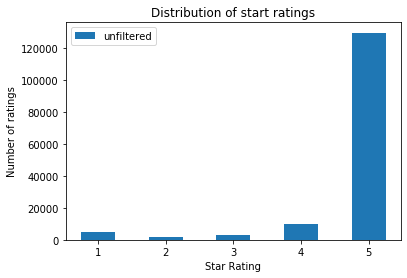

In [7]:
import matplotlib.pyplot as plt
def categorical_plot(names, *dicts):
    #plt.figure(figsize=(10, 5))
    plt.title('Distribution of start ratings')
    for i, d in enumerate(dicts):
        items = sorted(d.items()) 
        category, value = zip(*items)
        plt.bar(category, value, width=0.5, label=names[i])
    plt.xlabel('Star Rating')
    plt.ylabel('Number of ratings')
    plt.legend(loc='best')
    plt.show()

categorical_plot(["unfiltered"], ratings_count)

### Task 2
Repeat the above question, but generate the distribution (a) only for reviews that are ‘verified,’ and (b) only for reviews that are not verified. Write out the values or generate a plot to show
the difference between these distributions.

In [10]:
ratings_count_verified, ratings_count_notverified = defaultdict(int), defaultdict(int)

for d in dataset:
    if d['verified_purchase'] == 'Y':
        ratings_count_verified[d['star_rating']] += 1
    else:
        ratings_count_notverified[d['star_rating']] += 1
ratings_count_verified, ratings_count_notverified

(defaultdict(int, {5: 118974, 1: 4000, 4: 8940, 2: 1344, 3: 2784}),
 defaultdict(int, {5: 10735, 4: 919, 3: 372, 1: 793, 2: 225}))

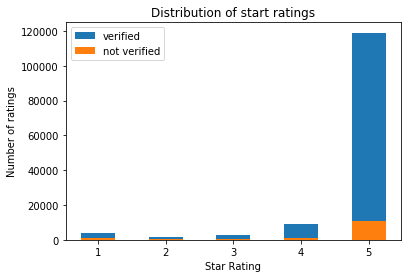

In [11]:
categorical_plot(["verified", "not verified"], ratings_count_verified, ratings_count_notverified)

### Task 3
Train a simple predictor to predict the star rating using two features.
Report the values of θ0, θ1, and θ2. Briefly describe your interpretation of these values, i.e., what do θ0,
θ1, and θ2 represent? Explain these in terms of the features and labels, e.g. if the coefficient of ‘review
length’ is negative, what would that say about verified versus unverified reviews 

In [12]:
from sklearn.linear_model import LinearRegression
def feature(datum):
    return [1, datum['verified_purchase'] == 'Y', len(datum['review_body'])]
    
X = [feature(d) for d in dataset]
y = [d['star_rating'] for d in dataset]
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
print("THETA: {}".format(theta))

THETA: [ 4.84461817e+00  5.04148265e-02 -1.24659895e-03]


$\theta_0$, $\theta_1$ and $\theta_2$ represent the the bias and the two weights respectfully for our line $y = \theta x + b$ where $\theta_0$ is the bias b and $\theta$ is our weight vector consisting of the weights $\theta_1$ and $\theta_2$. The bias represents the intercept where the line would intercept the y-axis. So if both $x_1$ and $x_2$ should turn out to be 0 from our feature vector, the linear model would return the bias as the predicted value. 

Let us say $\theta = [ 4.8,  5.0, -0.001]$ from the np.linalg.lstsq output. $\theta_0 = 4.8$ is the bias. $\theta_1 = 5.0$ which in our case represents the weight for the "review is verified" feature and $\theta_2 = -0.001$ is the weight for the "review length" feature. A higher weight value, indicates that it has a higher influence in the analysis than the weights with smaller values. So the fact that review length got a weight value of -0.001 indicates that it does have a big influence on the prediction for the star rating label.

So we can say that the coefficient of review and the coefficient of unverified reviews are two features that are linearly related.

### Task 4
Train another predictor that only uses one feature. Report the values of θ0 and θ1. Note that coefficient you found here might be quite different (i.e., much
larger or smaller) than the one from Question 3, even though these coefficients refer to the same feature.
Provide an explanation as to why these coefficients might vary so significantly

In [13]:
def feature(datum):
    return [1, datum['verified_purchase'] == 'Y']
    
X = [feature(d) for d in dataset]
y = [d['star_rating'] for d in dataset]
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
theta = model.coef_
print("THETA: {}".format(theta))

THETA: [4.57758356 0.16852426]


The results for $\theta_1$ we got here were significantly smaler than what we got from our last predictor. In this case we removed the feature for the review length, so the only feature that are taking into account now is the "review is verified" attraibute. Since this does not have to compensate for the influence that the review length attribute had on the model from last time, the weight value $\theta_1$ does not has to be that big.

### Task 5
Split the data into two fractions – the first 90% for training, and the remaining 10% testing (based on
the order they appear in the file). Train the same model as in Question 4 on the training set only. What
is the model’s MSE on the training and on the test set?

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)


# Fit the model
linear_model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

def mse_train_and_test(model, data_split):
    X_train, X_test, y_train, y_test = data_split
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    return mse_train, mse_test

mse_train, mse_test = mse_train_and_test(model, (X_train, X_test, y_train, y_test))
print("\n MSE_TRAININGSET: {} \n MSE_TESTSET: {}".format(mse_train, mse_test))



 MSE_TRAININGSET: 0.6557415620280947 
 MSE_TESTSET: 0.9713823241630068


### Task 6
Using the test set from Question 5, report the Mean Absolute Error (MAE) and R2
coefficient for your predictor (on the test set).



In [15]:
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score
y_test_pred = model.predict(X_test)

# Mean Absolute Error
mae_test = mean_absolute_error(y_test, y_test_pred)

# R^2 Coefficient
r2_test = r2_score(y_test, y_test_pred)

print("\n MEAN_ABSOLUTE_ERROR: {} \n R2_COEFFICIENT: {}".format(mae_test, r2_test))



 MEAN_ABSOLUTE_ERROR: 0.6228362918843261 
 R2_COEFFICIENT: -0.04908811430848825


A negative $R^2$ means that the model fits worse than a horizontal line, which is not a good sign. It is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

### Task 7
Repeat the above experiment, varying the size of the training and test fractions between
5% and 95% for training (using the complement for testing). Show how the training and test error vary
as a function of the training set size (again using a simple plot or table). Does the size of the training
set make a significant difference in testing performance? Comment on why it might or might not make
a significant difference in this instance 

In [16]:
traning_errors, test_errors, r2_scores, accuracies = [], [], [], []

train_sizes = np.arange(0.05, 1, 0.05)
for train_size in train_sizes:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_size), shuffle=False)
    
    # Train the model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    
    # Calculate the error
    mse_train, mse_test = mse_train_and_test(model, (X_train, X_test, y_train, y_test))
    traning_errors.append(mse_train)
    test_errors.append(mse_test)
    
    # Extra stats
    test_predictions = model.predict(X_test)
    r2_scores.append(r2_score(y_test, test_predictions))
    accuracies.append(sum(np.round(test_predictions) == y_test) / len(y_test))

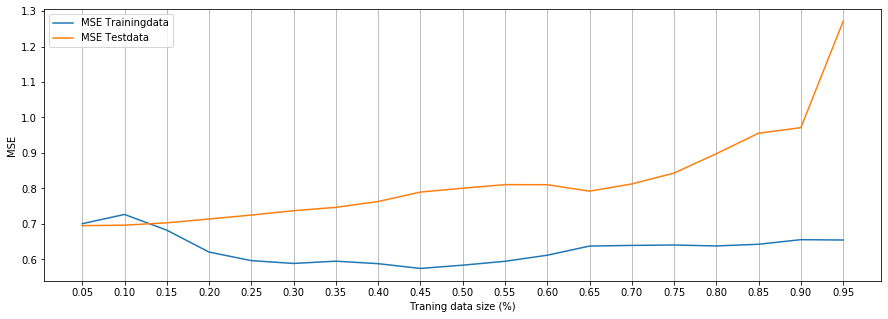

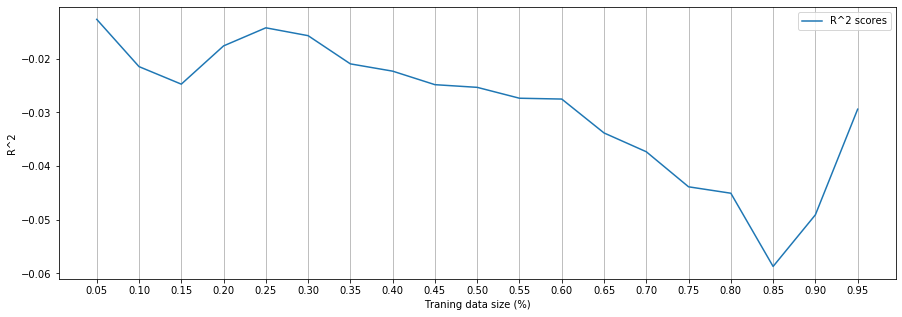

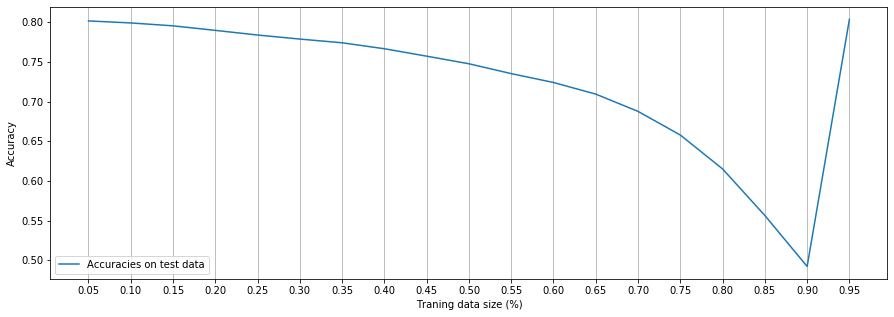

In [17]:
# Plot them to see how the MSE changes as the size of the trnaingdata change
plt.figure(figsize=(15,5))
plt.plot(train_sizes, traning_errors, label="MSE Trainingdata")
plt.plot(train_sizes, test_errors, label="MSE Testdata")
plt.xlabel('Traning data size (%)')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.gca().xaxis.grid(True)
plt.xticks(train_sizes)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(train_sizes, r2_scores, label="R^2 scores")
plt.xlabel('Traning data size (%)')
plt.ylabel('R^2')
plt.legend(loc='best')
plt.gca().xaxis.grid(True)
plt.xticks(train_sizes)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(train_sizes, accuracies, label="Accuracies on test data")
plt.xlabel('Traning data size (%)')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.gca().xaxis.grid(True)
plt.xticks(train_sizes)
plt.show()

From the graph we can clearly see that we have a model that are not predicting quite good. In our case, the bigger the training set, the worse model we get. The $R^2$ coefficient is generally bad as it is around 0 all the way, which  means that the model fits worse than a horizontal line, which is not a good sign. It is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line. From the accuracy, we can also see that is is never getting over 70%, which is not much better than guessing. 

Why does not the size of the training set make a big difference? Maybe because the is verified feature does not make a big difference for what a users rating is, it does not correlate.

Another reason we can talk about, is the fact that we are always testing on the oldest values in the dataset. We do not shuffle the data, so if there should be a correlation between when the review was made, and the rating, this should make a difference.

# Classification
In this question we’ll alter the prediction from our regression task, so that we are now classifying whether a
review is verified. Continue using the 90%/10% training and test sets you constructed previously, i.e., train on
the training set and report the error/accuracy on the testing set.

### Task 8
First, let’s train a predictor that estimates whether a review is verified using the rating and the length. Train a logistic regressor to make the above prediction (you may use a logistic regression library with default parameters, e.g. linear model.LogisticRegression() from sklearn). Report the classification accuracy
of this predictor. Report also the proportion of labels that are positive (i.e., the proportion of reviews
that are verified) and the proportion of predictions that are positive.

In [18]:
def feature(datum):
    return [1, datum['star_rating'], len(datum['review_body'])]

# Split the data 90/10
X = [feature(d) for d in dataset]
y = [d['verified_purchase'] == 'Y' for d in dataset]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

In [19]:
from sklearn.linear_model import LogisticRegression

# Fit the model
model = LogisticRegression(solver="lbfgs", fit_intercept=False)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
# Make predictions
predictions  = model.predict(X_test)
correctPredictions = predictions == y_test
accuracy = sum(correctPredictions / len(y_test))
positive_labels = sum(y_test)
positive_predictions = sum(predictions)
print("\n Accuracy: {} \n Positive labels: {} \n Positive predictions : {}".format(accuracy, positive_labels, positive_predictions))


 Accuracy: 0.5589241397813758 
 Positive labels: 8329 
 Positive predictions : 14895


So these predictions are not good a t all. It has a accuracy of 55%, which is basically guessing. It seems like the model i predicting that the review is verified almost all the time, since the size of the test data is 14909 and the model is predicting 14895 to be verified.

In [21]:
dataset[0]

{'marketplace': 'US',
 'customer_id': '24371595',
 'review_id': 'R27ZP1F1CD0C3Y',
 'product_id': 'B004LLIL5A',
 'product_parent': '346014806',
 'product_title': 'Amazon eGift Card - Celebrate',
 'product_category': 'Gift Card',
 'star_rating': 5,
 'helpful_votes': '0',
 'total_votes': '0',
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'Five Stars',
 'review_body': 'Great birthday gift for a young adult.',
 'review_date': '2015-08-31\n'}

### Task 9
Considering same prediction problem as above, can you come up with a more accurate predictor (e.g. using
features from the text, timestamp, etc.)? Write down the feature vector you design, and report its
train/test accuracy.


In [22]:
def feature(datum):
    date = list(map(int, datum['review_date'].split('-')))
    time = 10000 * (date[0]) + 100 * (date[1]) + 1*(date[2])
    long_text = len(datum['review_body']) < 200
    return [1, long_text, time]

# Split data
X = [feature(d) for d in dataset]
y = [d['verified_purchase'] == 'Y' for d in dataset]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)

l_train, l_test = len(y_train), len(y_test)

# Train model
model = LogisticRegression(solver='lbfgs', fit_intercept=False)
model.fit(X_train, y_train)

# Do predictions
predictions_train  = model.predict(X_train)
predictions_test = model.predict(X_test)

correct_predictions_train = predictions_train == y_train
correct_predictions_test = predictions_test == y_test

accuracy_train = sum(correct_predictions_train) / len(y_train)
accuracy_test = sum(correct_predictions_test) / len(y_test)

print("\n Accuracy trainingset: {}  \n Accuracy testset: {}".format(accuracy_train, accuracy_test))



 Accuracy trainingset: 0.9125110861026853  
 Accuracy testset: 0.9124689784693809


The smartest thing we can do here to get better performance is to shuffle the dataset before we split it. Just by doing this we go from an accuracy of 55% to over 90%. This might be of reasons mentioned earlier, that we did not check our label imbalance over the dataset, and that they are actually clustering up in time.

Features that I am trying out and why:
* date (converted to an integer): because I think the labels may have a correlation with the time the review was made.
* long_text (<200): I went over the dataset, and it did not actually seemed like the people who where verified did write very long reviews. This went actually against what I initially thougt. It seemed reasonable that people that have verified that they received the item, would write longer.
